In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import joblib

# Loadig the data 
data = pd.read_csv("cap_packs (1).csv")

# handling missing values
data['src_mac'] = data['src_mac'].replace(['-1', '', None], '00:00:00:00:00:00')
data['dest_mac'] = data['dest_mac'].replace(['-1', '', None], '00:00:00:00:00:00')
data['src_port'] = data['src_port'].replace(['-1', '', None], '0')
data['dst_port'] = data['dst_port'].replace(['-1', '', None], '0')

# converting to strings before label encoding 
columns_to_convert = ['protocol', 'src_ip', 'dst_ip', 'src_mac', 'dest_mac', 'eth_proto', 'src_port', 'dst_port']
data[columns_to_convert] = data[columns_to_convert].astype(str)

# encoding catgicals forms
le_protocol = LabelEncoder()
data['protocol'] = le_protocol.fit_transform(data['protocol'])

le_ip = LabelEncoder()
data['src_ip'] = le_ip.fit_transform(data['src_ip'])
data['dst_ip'] = le_ip.fit_transform(data['dst_ip'])

# Selecting features for training 
features = data[['src_mac', 'dest_mac', 'eth_proto', 'src_ip', 'dst_ip', 'protocol', 'src_port', 'dst_port']]

# encoding mac address and eth_proto
le_mac = LabelEncoder()
features['src_mac'] = le_mac.fit_transform(features['src_mac'])
features['dest_mac'] = le_mac.fit_transform(features['dest_mac'])
features['eth_proto'] = le_mac.fit_transform(features['eth_proto'])

# Convert all feature columns to numeric (where applicable), coercing errors to NaN
features = features.apply(pd.to_numeric, errors='coerce')

# Check for NaN values and handle them  replace with the mean
features.fillna(features.mean(), inplace=True)

# Train Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)  # 10% of the data is anomalies
model.fit(features)

# Predict anomalies
data['anomaly'] = model.predict(features)
data['anomaly'] = data['anomaly'].apply(lambda x: 'normal' if x == 1 else 'anomaly')

# Save model and encoders for later use
joblib.dump(model, 'isolation_forest_anomaly_model.pkl')
joblib.dump(le_protocol, 'protocol_encoder.pkl')
joblib.dump(le_ip, 'ip_encoder.pkl')
joblib.dump(le_mac, 'mac_encoder.pkl')

# Display a few rows to see the result
print(data.head())


C:\Users\Acer\AppData\Local\Temp\ipykernel_30948\65168600.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['src_mac'] = le_mac.fit_transform(features['src_mac'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_30948\65168600.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['dest_mac'] = le_mac.fit_transform(features['dest_mac'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_30948\65168600.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

             src_mac           dest_mac eth_proto  src_ip  dst_ip  protocol  \
0  52:54:00:12:35:00  08:00:27:1E:36:4A         8    2133    1233         3   
1                                               6     176       2         2   
2  00:00:00:00:00:00  00:00:00:00:00:00         6     966     734         2   
3  08:00:27:1E:36:4A  52:54:00:12:35:00         8    2133    1233         3   
4                                               6       1     566         2   

  src_port dst_port                                             packet anomaly  
0        0        0                                                NaN  normal  
1                                                                       normal  
2        0        0  b'\x17\x03\x03\x00\x13\x9dM\x08\xf6\x90\xb1N&4...  normal  
3        0        0                                                NaN  normal  
4                                                                       normal  



Summary Statistics:
--------------------------------------------------
Total samples: 27981
Normal samples: 25502 (91.1%)
Anomaly samples: 2479 (8.9%)

Protocol Distribution by Class:
--------------------------------------------------
anomaly   anomaly  normal
protocol                 
0           22.51    0.00
1           68.62    3.85
2            8.59   59.56
3            0.28   36.59

Ethernet Protocol Distribution by Class:
--------------------------------------------------
anomaly    anomaly  normal
eth_proto                 
1            22.51    0.00
1544          0.28    0.04
17           68.62    3.85
6             8.59   59.56
8             0.00   36.55

Top Source MAC Addresses in Anomalies:
--------------------------------------------------
src_mac
00:00:00:00:00:00    1678
                      794
52:54:00:12:35:00       7
Name: count, dtype: int64

Feature Value Counts for Anomalies:
--------------------------------------------------

PROTOCOL Distribution in Anomalies

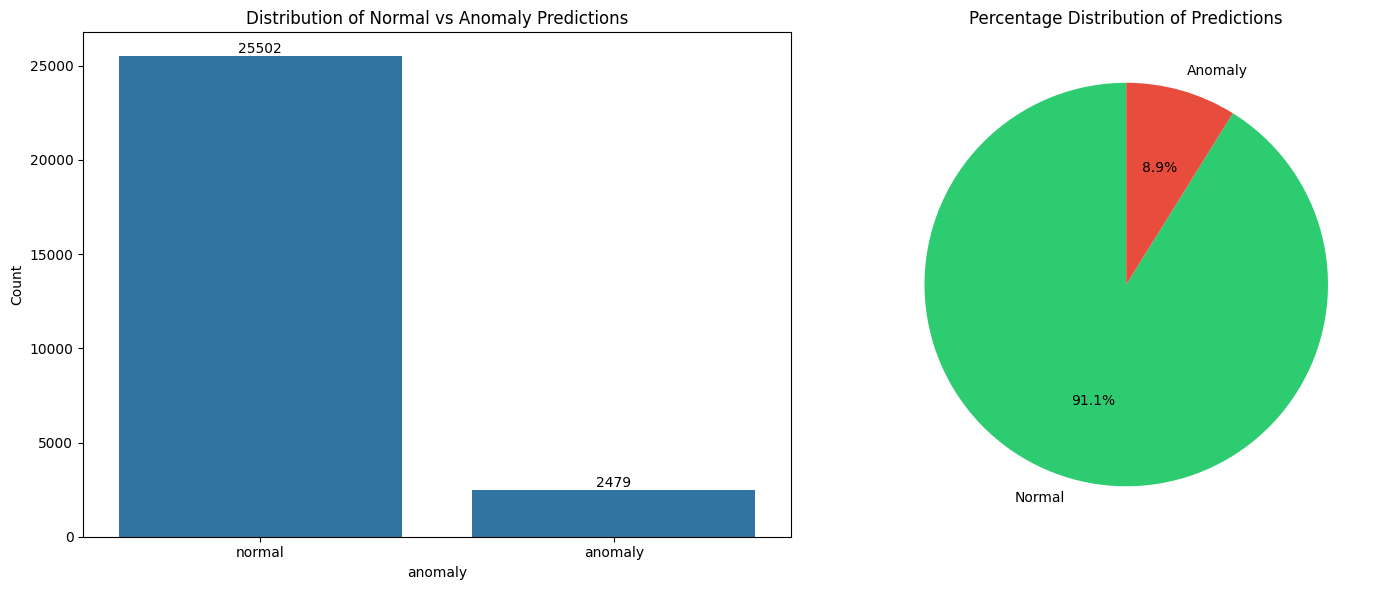

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_anomalies(data):
    """
    Analyze and visualize the anomaly detection results with proper data cleaning
    """
    # Count the occurrences of each prediction
    prediction_counts = data['anomaly'].value_counts()
    
    # Calculate percentages
    total_samples = len(data)
    normal_percent = (prediction_counts['normal'] / total_samples) * 100
    anomaly_percent = (prediction_counts['anomaly'] / total_samples) * 100
    
    # Create a figure with two subplots (removing the problematic port analysis)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Distribution of predictions
    sns.countplot(data=data, x='anomaly', ax=ax1)
    ax1.set_title('Distribution of Normal vs Anomaly Predictions')
    ax1.set_ylabel('Count')
    
    # Add count labels on top of bars
    for i in ax1.containers:
        ax1.bar_label(i)
    
    # Plot 2: Pie chart
    colors = ['#2ecc71', '#e74c3c']
    ax2.pie([normal_percent, anomaly_percent], 
            labels=['Normal', 'Anomaly'],
            colors=colors,
            autopct='%1.1f%%',
            startangle=90)
    ax2.set_title('Percentage Distribution of Predictions')
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total samples: {total_samples}")
    print(f"Normal samples: {prediction_counts['normal']} ({normal_percent:.1f}%)")
    print(f"Anomaly samples: {prediction_counts['anomaly']} ({anomaly_percent:.1f}%)")
    
    # Protocol analysis
    print("\nProtocol Distribution by Class:")
    print("-" * 50)
    protocol_dist = pd.crosstab(data['protocol'], data['anomaly'], normalize='columns') * 100
    print(protocol_dist.round(2))
    
    # Ethernet Protocol Analysis
    print("\nEthernet Protocol Distribution by Class:")
    print("-" * 50)
    eth_dist = pd.crosstab(data['eth_proto'], data['anomaly'], normalize='columns') * 100
    print(eth_dist.round(2))
    
    # MAC Address Analysis
    print("\nTop Source MAC Addresses in Anomalies:")
    print("-" * 50)
    anomaly_macs = data[data['anomaly'] == 'anomaly']['src_mac'].value_counts().head(5)
    print(anomaly_macs)
    
    # Feature Distribution Analysis
    print("\nFeature Value Counts for Anomalies:")
    print("-" * 50)
    for feature in ['protocol', 'eth_proto']:
        print(f"\n{feature.upper()} Distribution in Anomalies:")
        print(data[data['anomaly'] == 'anomaly'][feature].value_counts().head(5))
    
    # Port Analysis (with proper cleaning)
    try:
        # Clean port data by replacing invalid values with 0
        clean_src_ports = pd.to_numeric(data['src_port'].replace([' ', '', '-1'], '0'), errors='coerce').fillna(0).astype(int)
        clean_dst_ports = pd.to_numeric(data['dst_port'].replace([' ', '', '-1'], '0'), errors='coerce').fillna(0).astype(int)
        
        print("\nPort Statistics:")
        print("-" * 50)
        print("Source Ports:")
        print(f"Mean: {clean_src_ports.mean():.2f}")
        print(f"Most common: {clean_src_ports.mode().iloc[0]}")
        print("\nDestination Ports:")
        print(f"Mean: {clean_dst_ports.mean():.2f}")
        print(f"Most common: {clean_dst_ports.mode().iloc[0]}")
        
    except Exception as e:
        print("\nError in port analysis:", str(e))
    
    return fig

# Call the analysis function
fig = analyze_anomalies(data)
plt.show()


Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     Anomaly       0.26      0.26      0.26      2479
      Normal       0.93      0.93      0.93     25501

    accuracy                           0.87     27980
   macro avg       0.59      0.59      0.59     27980
weighted avg       0.87      0.87      0.87     27980


Detailed Metrics:
--------------------------------------------------

Class Distribution:
normal: 25502 samples (91.14%)
anomaly: 2479 samples (8.86%)

Transition Probabilities:
Anomaly->Normal: 74.06%
Normal->Anomaly: 7.20%
Anomaly->Anomaly: 25.94%
Normal->Normal: 92.80%

Sequence Statistics:
Average sequence length: 7.62
Maximum sequence length: 5572
Minimum sequence length: 1
Median sequence length: 2.00


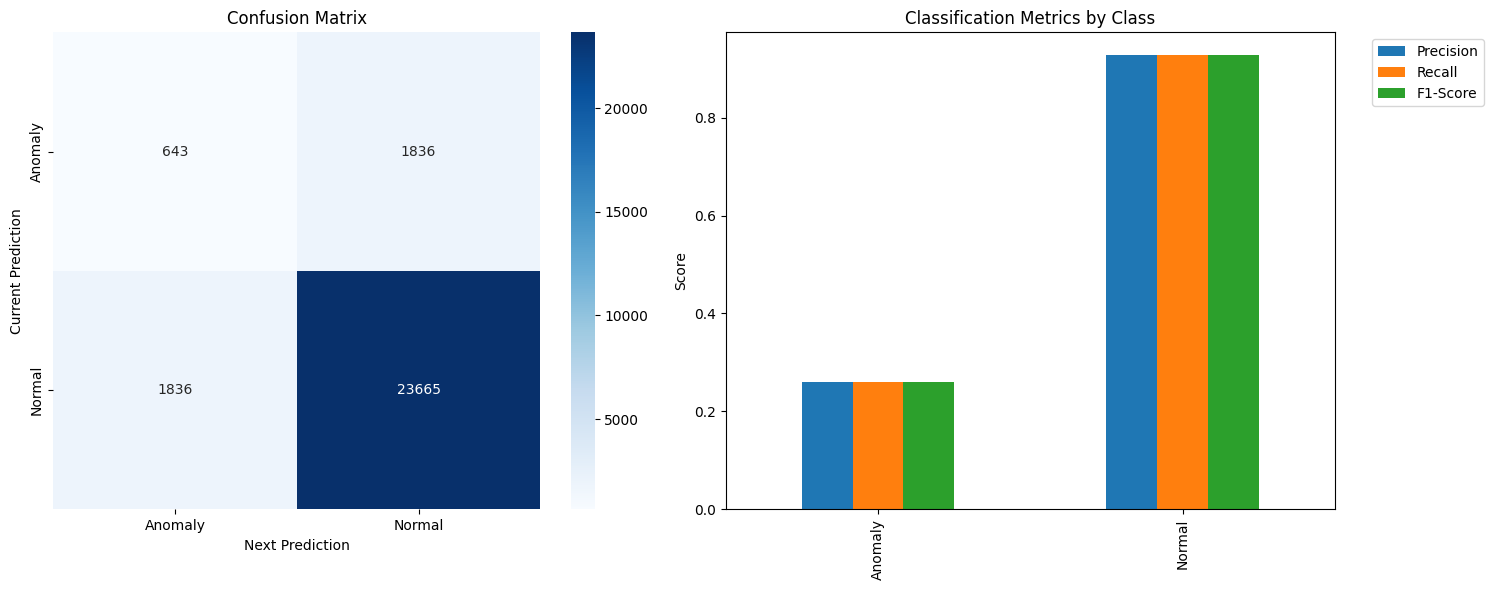

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def create_performance_analysis(data):
    """
    Create comprehensive performance analysis including classification report 
    and visualizations
    """
    # Convert predictions to binary format for sklearn metrics
    y_true = (data['anomaly'] == 'normal').astype(int)
    
    # Create the classification report
    report = classification_report(y_true[:-1], y_true[1:], 
                                 target_names=['Anomaly', 'Normal'],
                                 output_dict=True)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true[:-1], y_true[1:])
    
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Confusion Matrix Heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Anomaly', 'Normal'],
                yticklabels=['Anomaly', 'Normal'],
                ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('Current Prediction')
    ax1.set_xlabel('Next Prediction')
    
    # Plot 2: Classification Metrics Bar Plot
    metrics = {
        'Precision': [report['Anomaly']['precision'], report['Normal']['precision']],
        'Recall': [report['Anomaly']['recall'], report['Normal']['recall']],
        'F1-Score': [report['Anomaly']['f1-score'], report['Normal']['f1-score']]
    }
    
    df_metrics = pd.DataFrame(metrics, index=['Anomaly', 'Normal'])
    df_metrics.plot(kind='bar', ax=ax2)
    ax2.set_title('Classification Metrics by Class')
    ax2.set_ylabel('Score')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Print detailed classification report
    print("\nClassification Report:")
    print("-" * 50)
    print(classification_report(y_true[:-1], y_true[1:], 
                              target_names=['Anomaly', 'Normal']))
    
    # Additional metrics
    print("\nDetailed Metrics:")
    print("-" * 50)
    
    # Calculate class distribution
    class_distribution = data['anomaly'].value_counts()
    total_samples = len(data)
    
    print("\nClass Distribution:")
    for class_name, count in class_distribution.items():
        percentage = (count/total_samples) * 100
        print(f"{class_name}: {count} samples ({percentage:.2f}%)")
    
    # Calculate transition probabilities
    transitions = {'Anomaly->Normal': cm[0,1]/cm[0,:].sum() if cm[0,:].sum() > 0 else 0,
                  'Normal->Anomaly': cm[1,0]/cm[1,:].sum() if cm[1,:].sum() > 0 else 0,
                  'Anomaly->Anomaly': cm[0,0]/cm[0,:].sum() if cm[0,:].sum() > 0 else 0,
                  'Normal->Normal': cm[1,1]/cm[1,:].sum() if cm[1,:].sum() > 0 else 0}
    
    print("\nTransition Probabilities:")
    for transition, prob in transitions.items():
        print(f"{transition}: {prob:.2%}")
    
    # Calculate sequence statistics
    sequences = []
    current_sequence = 1
    
    for i in range(1, len(data)):
        if data['anomaly'].iloc[i] == data['anomaly'].iloc[i-1]:
            current_sequence += 1
        else:
            sequences.append(current_sequence)
            current_sequence = 1
            
    sequences.append(current_sequence)  # Add the last sequence
    
    print("\nSequence Statistics:")
    print(f"Average sequence length: {np.mean(sequences):.2f}")
    print(f"Maximum sequence length: {np.max(sequences)}")
    print(f"Minimum sequence length: {np.min(sequences)}")
    print(f"Median sequence length: {np.median(sequences):.2f}")
    
    return fig

# Generate the analysis
fig = create_performance_analysis(data)
plt.show()


Confusion Matrix Analysis:
--------------------------------------------------
Total pairs analyzed: 27980
Prediction consistency: 86.88%
Transition rate: 13.12%

Interpretation:
--------------------------------------------------
- Diagonal elements (top-left to bottom-right) show consistent predictions
- Off-diagonal elements show transitions between normal and anomaly states
- 23665 consecutive normal predictions
- 643 consecutive anomaly predictions
- 1836 transitions from anomaly to normal
- 1836 transitions from normal to anomaly

Prediction Statistics:
--------------------------------------------------
Total samples: 27981
Normal samples: 25502 (91.14%)
Anomaly samples: 2479 (8.86%)

Sequence Length Analysis:
--------------------------------------------------
Normal sequences:
Average length: 13.88
Max length: 5572

Anomaly sequences:
Average length: 1.35
Max length: 2


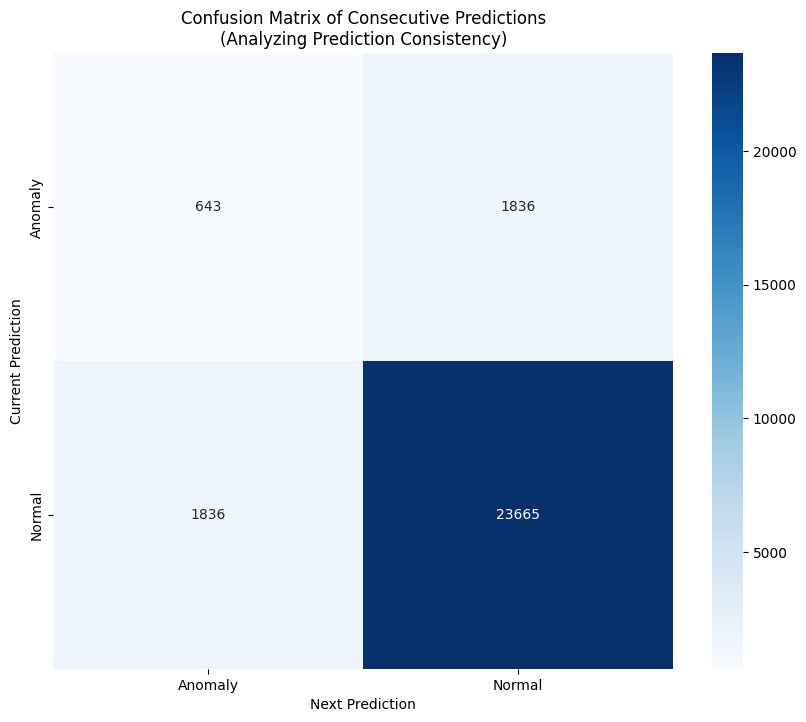

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(data):
    """
    Create and visualize a confusion matrix for the anomaly detection results
    """
    # Convert predictions to binary (1 for normal, 0 for anomaly)
    y_pred = (data['anomaly'] == 'normal').astype(int)
    
    # Since this is unsupervised learning, we'll use the predictions to create a confusion matrix
    # We'll consider consecutive pairs of predictions to analyze consistency
    y_pred_shifted = y_pred.shift(-1)
    
    # Remove the last row (which would have NaN from the shift)
    y_pred = y_pred[:-1]
    y_pred_shifted = y_pred_shifted[:-1]
    
    # Create confusion matrix
    cm = confusion_matrix(y_pred, y_pred_shifted)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Anomaly', 'Normal'],
                yticklabels=['Anomaly', 'Normal'])
    
    plt.title('Confusion Matrix of Consecutive Predictions\n(Analyzing Prediction Consistency)')
    plt.ylabel('Current Prediction')
    plt.xlabel('Next Prediction')
    
    # Calculate metrics
    total = np.sum(cm)
    consistency = (cm[0,0] + cm[1,1]) / total
    transition_rate = (cm[0,1] + cm[1,0]) / total
    
    # Print analysis
    print("\nConfusion Matrix Analysis:")
    print("-" * 50)
    print(f"Total pairs analyzed: {total}")
    print(f"Prediction consistency: {consistency:.2%}")
    print(f"Transition rate: {transition_rate:.2%}")
    print("\nInterpretation:")
    print("-" * 50)
    print("- Diagonal elements (top-left to bottom-right) show consistent predictions")
    print("- Off-diagonal elements show transitions between normal and anomaly states")
    print(f"- {cm[1,1]} consecutive normal predictions")
    print(f"- {cm[0,0]} consecutive anomaly predictions")
    print(f"- {cm[0,1]} transitions from anomaly to normal")
    print(f"- {cm[1,0]} transitions from normal to anomaly")
    
    # Additional statistics
    print("\nPrediction Statistics:")
    print("-" * 50)
    anomaly_count = len(data[data['anomaly'] == 'anomaly'])
    normal_count = len(data[data['anomaly'] == 'normal'])
    total_count = len(data)
    
    print(f"Total samples: {total_count}")
    print(f"Normal samples: {normal_count} ({normal_count/total_count:.2%})")
    print(f"Anomaly samples: {anomaly_count} ({anomaly_count/total_count:.2%})")
    
    # Create sequence length analysis
    predictions = data['anomaly'].values
    current_type = predictions[0]
    current_count = 1
    sequence_lengths = {'normal': [], 'anomaly': []}
    
    for pred in predictions[1:]:
        if pred == current_type:
            current_count += 1
        else:
            sequence_lengths[current_type].append(current_count)
            current_type = pred
            current_count = 1
    
    # Add the last sequence
    sequence_lengths[current_type].append(current_count)
    
    print("\nSequence Length Analysis:")
    print("-" * 50)
    print("Normal sequences:")
    print(f"Average length: {np.mean(sequence_lengths['normal']):.2f}")
    print(f"Max length: {np.max(sequence_lengths['normal'])}")
    print("\nAnomaly sequences:")
    print(f"Average length: {np.mean(sequence_lengths['anomaly']):.2f}")
    print(f"Max length: {np.max(sequence_lengths['anomaly'])}")
    
    return plt.gcf()

# Create and display the confusion matrix
fig = create_confusion_matrix(data)
plt.show()

In [5]:
from joblib import dump

# Save the model
dump(model, 'anomaly_detection_model.joblib')


['anomaly_detection_model.joblib']

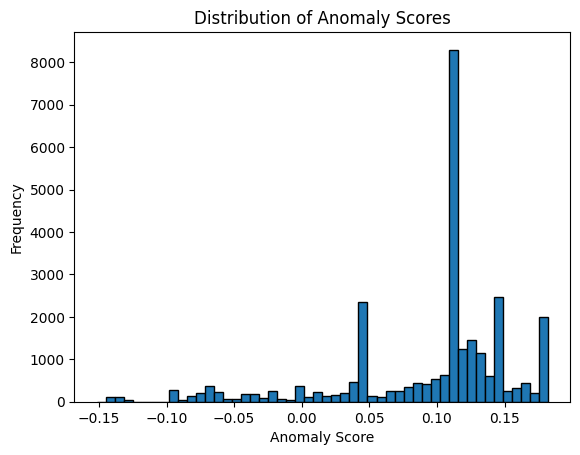

In [6]:
import matplotlib.pyplot as plt

# Get anomaly scores
scores = model.decision_function(features)

# Visualize the scores
plt.hist(scores, bins=50, edgecolor='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()


Analayszing Anomalies

In [7]:
# Extracting anomalous data points
anomalies = data[data['anomaly'] == 'anomaly']
print(anomalies)


                 src_mac           dest_mac eth_proto  src_ip  dst_ip  \
13     52:54:00:12:35:00  08:00:27:1E:36:4A      1544    2133    1233   
16     00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
19     00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
22     00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
25     00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
...                  ...                ...       ...     ...     ...   
27796                                               1      22       2   
27797  00:00:00:00:00:00  00:00:00:00:00:00         1    2133    1233   
27800  00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
27815  00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   
27818  00:00:00:00:00:00  00:00:00:00:00:00        17    2133    1233   

       protocol src_port dst_port  \
13            3        0        0   
16            1    59460       53   
19          

Investigate Anomalous Entries:

In [8]:
# Example to display a specific anomalous entry
specific_anomaly = anomalies.iloc[0]  # Change index to inspect different anomalies
print(specific_anomaly)


src_mac      52:54:00:12:35:00
dest_mac     08:00:27:1E:36:4A
eth_proto                 1544
src_ip                    2133
dst_ip                    1233
protocol                     3
src_port                     0
dst_port                     0
packet                     NaN
anomaly                anomaly
Name: 13, dtype: object


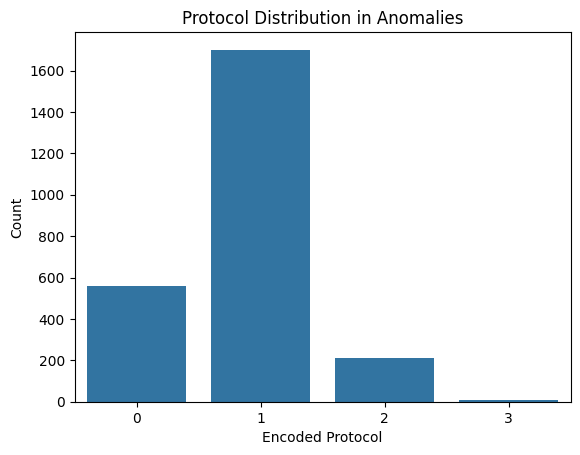

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Count plot of protocols in anomalies
sns.countplot(x='protocol', data=anomalies)
plt.title('Protocol Distribution in Anomalies')
plt.xlabel('Encoded Protocol')
plt.ylabel('Count')
plt.show()


Adding a new datset to predict

In [10]:
new_data = pd.read_csv("cap_packs.csv")

In [134]:
# Handle missing values
new_data['src_mac'] = new_data['src_mac'].replace(['-1', '', None], '00:00:00:00:00:00')
new_data['dest_mac'] = new_data['dest_mac'].replace(['-1', '', None], '00:00:00:00:00:00')
new_data['src_port'] = new_data['src_port'].replace(['-1', '', None], '0')
new_data['dst_port'] = new_data['dst_port'].replace(['-1', '', None], '0')

# Convert to strings for encoding
columns_to_convert = ['protocol', 'src_ip', 'dst_ip', 'src_mac', 'dest_mac', 'eth_proto', 'src_port', 'dst_port']
new_data[columns_to_convert] = new_data[columns_to_convert].astype(str)


In [136]:
model = joblib.load('isolation_forest_anomaly_model.pkl')
le_protocol = joblib.load('protocol_encoder.pkl')
le_ip = joblib.load('ip_encoder.pkl')
le_mac = joblib.load('mac_encoder.pkl')


In [137]:

# encoding catgicals forms
le_protocol = LabelEncoder()
new_data['protocol'] = le_protocol.fit_transform(new_data['protocol'])

le_ip = LabelEncoder()
new_data['src_ip'] = le_ip.fit_transform(new_data['src_ip'])
new_data['dst_ip'] = le_ip.fit_transform(new_data['dst_ip'])

# Selecting features for training 
features = new_data[['src_mac', 'dest_mac', 'eth_proto', 'src_ip', 'dst_ip', 'protocol', 'src_port', 'dst_port']]

# encoding mac address and eth_proto
le_mac = LabelEncoder()
features['src_mac'] = le_mac.fit_transform(features['src_mac'])
features['dest_mac'] = le_mac.fit_transform(features['dest_mac'])
features['eth_proto'] = le_mac.fit_transform(features['eth_proto'])

# Convert all feature columns to numeric (where applicable), coercing errors to NaN
features = features.apply(pd.to_numeric, errors='coerce')

# Check for NaN values and handle them  replace with the mean
features.fillna(features.mean(), inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_17440\297974155.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['src_mac'] = le_mac.fit_transform(features['src_mac'])
C:\Users\user\AppData\Local\Temp\ipykernel_17440\297974155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['dest_mac'] = le_mac.fit_transform(features['dest_mac'])
C:\Users\user\AppData\Local\Temp\ipykernel_17440\297974155.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


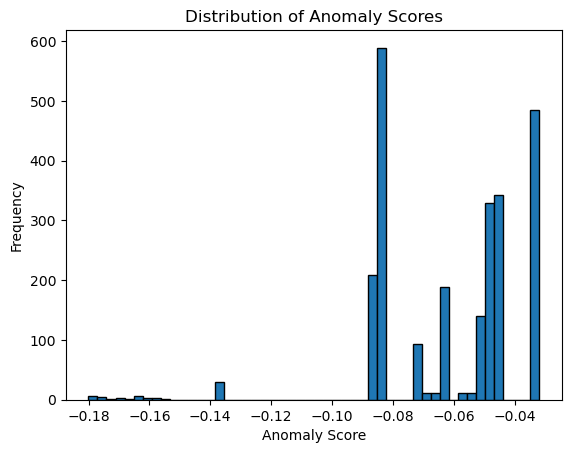

In [138]:
import matplotlib.pyplot as plt

# Get anomaly scores
scores = model.decision_function(features)

# Visualize the scores
plt.hist(scores, bins=50, edgecolor='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()


KeyError: 'anomaly'

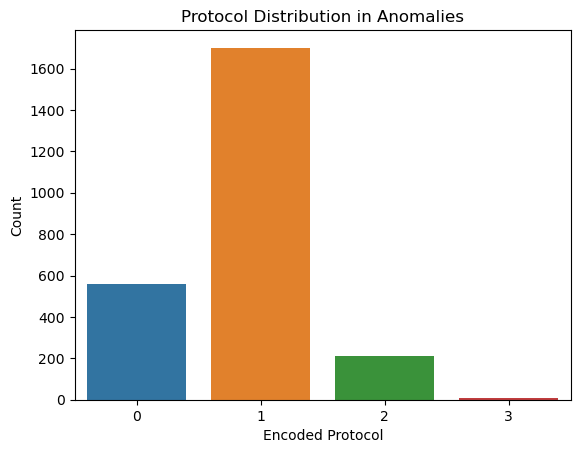

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Count plot of protocols in anomalies
sns.countplot(x='protocol', data=anomalies)
plt.title('Protocol Distribution in Anomalies')
plt.xlabel('Encoded Protocol')
plt.ylabel('Count')
plt.show()


In [108]:
features

,src_mac,dest_mac,eth_proto,src_ip,dst_ip,protocol,src_port,dst_port
0,2,3,2,66,66,2,0.000000,0.000000
1,0,0,0,0,1,0,431.743652,431.743652
2,1,1,0,66,66,0,33615.000000,53.000000
3,3,2,2,66,66,2,0.000000,0.000000
4,0,0,0,1,0,0,431.743652,431.743652
...,...,...,...,...,...,...,...,...
2476,0,0,1,0,9,1,431.743652,431.743652
2477,1,1,1,11,24,1,0.000000,0.000000
2478,3,2,2,66,66,2,0.000000,0.000000
2479,0,0,1,9,0,1,431.743652,431.743652


InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0 instead.

AttributeError: 'DataFrame' object has no attribute 'classes'